In [1]:
!pip install qiskit
!pip install qiskit-optimization
!pip install networkx
!pip install qiskit-ibmq-provider
!pip install pylatexenc

In [2]:
!pip install qiskit-ibm-runtime

In [3]:
!pip install rustworkx

In [4]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.jupyter import *
from qiskit.utils import QuantumInstance
from qiskit import Aer
#from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import VertexCover, Maxcut
import pandas as pd
import networkx as nx

In [6]:
from typing import Dict, List, Optional, Union

import networkx as nx
import numpy as np
from docplex.mp.model import Model
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.problems.quadratic_program import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications.graph_optimization_application import GraphOptimizationApplication

In [7]:
#IBMQ.save_account("7ec7c3d9c61b02577a80462aeed74b169ce4defa242d2b2fc5031cabfac5f8199274a09d822b1dcd65125930a20f7c7c5f147e4785837efcc84764640599e462", overwrite = True)

In [8]:
%run cred.sh

In [9]:
backend = service.backend("ibm_lagos")

In [10]:
#IBMQ.load_account()
#provider = IBMQ.get_provider()

In [11]:
data = pd.read_csv('hero-network.csv')
#heroes = {'MEDUSA/MEDUSALITH AM', 'WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ', 'ARAGORN','OVERMIND/GROM'}

In [25]:
heroes = {'MEDUSA/MEDUSALITH AM','ARCLIGHT/PHILLIPA SO','WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ',
          'ARAGORN','OVERMIND/GROM',}
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 895 to 569649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   87 non-null     object
 1   hero2   87 non-null     object
dtypes: object(2)
memory usage: 2.0+ KB


In [26]:
graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')

In [27]:
#mpl_draw(graph, pos=rx.shell_layout(graph), with_labels=True, edge_labels=str, node_color="#1192E8")

In [28]:
graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
matrix = nx.to_pandas_adjacency(graph, dtype=int)
adjacency = matrix.to_numpy()

max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
hamiltonian, offset = qp.to_ising()

#backend = Aer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

<ipython-input-28-379ddc302d81>:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)


In [29]:
from qiskit.circuit.library import QAOAAnsatz

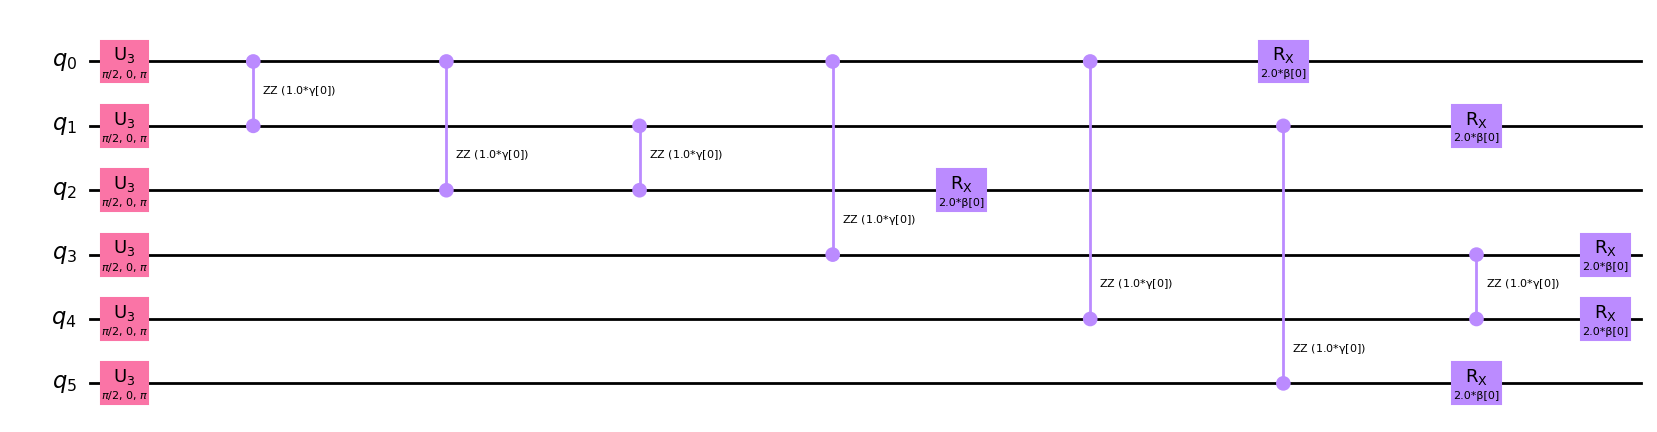

In [30]:
ansatz = QAOAAnsatz(hamiltonian, reps=1)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [31]:
# Sum the weights, and divide by 2

#offset = - sum(edge[2] for edge in edges) / 2
#print(f"""Offset: {offset}""")

In [32]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [33]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Add your token below
#service = QiskitRuntimeService(channel='ibm_quantum')
#backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

In [34]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

In [35]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [36]:
result = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

IBMRuntimeError: ignored

In [37]:
%qiskit_disable_job_watcher

In [38]:
print(result)

NameError: ignored

In [39]:
eigenvalue = cost_func(result.x, ansatz, hamiltonian, estimator)
print(f"""Eigenvalue: {eigenvalue}""")
print(f"""Max-Cut Objective: {eigenvalue + offset}""")

NameError: ignored

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(result.x)

# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]

# Close the session since we are now done with it
session.close()

In [ ]:
from qiskit.visualization import plot_distribution

probabilities = samp_dist.binary_probabilities()
plot_distribution(probabilities)